<a href="https://colab.research.google.com/github/saba-sohail/Pfizer-Vaccination-Rates/blob/main/Pfizer_Vaccination_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
import plotly.express as px
from catboost import CatBoostRegressor

In [3]:
drive.mount('/content/drive')
file_path1 = '/content/drive/MyDrive/Colab Notebooks/Weekly_Cumulative_Influenza_Vaccination_Coverage__Children_6_months_through_17_years__United_States_20240826.csv'
file_path2 = '/content/drive/MyDrive/Colab Notebooks/Weekly_Cumulative_Influenza_Vaccination_Coverage__Adults_18_and_Older__United_States_20240826.csv'

df_ped = pd.read_csv(file_path1)
df_adult = pd.read_csv(file_path2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_ped.columns.sort_values()
df_adult.columns.sort_values()

Index(['95 CI (%)', 'CI_Half_width_95pct', 'Current_Season_Week_Ending',
       'Demographic_Level', 'Demographic_Level_Sort', 'Demographic_Name',
       'Demographic_Name_Sort', 'Geographic_Level', 'Geographic_Name',
       'Geographic_Sort', 'Indicator_Category_Label',
       'Indicator_Category_Label_Sort', 'Indicator_Label', 'Influenza_Season',
       'Legend', 'Legend_Sort', 'Month_Week', 'ND_Weekly_Estimate',
       'Season_Sort', 'Suppression_Flag', 'Week_Ending', 'n_unweighted'],
      dtype='object')

In [5]:
df_ped.rename(columns={
        'CI_HalfWidth': 'CI_Half_width_95pct',
        'Current_Season_Week_Ending_Label': 'Current_Season_Week_Ending',
        'Demographic_Level_Sort_Order': 'Demographic_Level_Sort',
        'Demographic_Name_Sort_Order': 'Demographic_Name_Sort',
        'Geography_Level': 'Geographic_Level',
        'Geography_Name': 'Geographic_Name',
        'geography_level_sort_order': 'Geographic_Sort',
        'Indicator Category Label': 'Indicator_Category_Label',
        'Legend_Label': 'Legend',
        'Point_Estimate': 'ND_Weekly_Estimate'
        }, inplace=True)

df = pd.concat([df_adult,df_ped],ignore_index=True)

In [6]:
df.head()

,Geographic_Level,Geographic_Name,Demographic_Level,Demographic_Name,Indicator_Label,Indicator_Category_Label,Month_Week,Week_Ending,ND_Weekly_Estimate,CI_Half_width_95pct,...,Legend,95 CI (%),Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
0,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,NaN,30.8,7.8784,...,"2023-2024, Arizona, Overall (18+ years)",22.9 - 38.7,4.0,1,1,14,3,3140101,NaN,NaN
1,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,NaN,6.8,4.1669,...,"2023-2024, Arizona, Overall (18+ years)",2.6 - 11.0,2.0,1,1,14,3,3140101,NaN,NaN
2,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,NaN,22.3,7.6134,...,"2023-2024, Arizona, Overall (18+ years)",14.7 - 29.9,3.0,1,1,14,3,3140101,NaN,NaN
3,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,1.0,1,1,14,3,3140101,NaN,NaN
4,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,NaN,1,1,14,3,3140101,NaN,NaN


In [7]:
df.describe()

,ND_Weekly_Estimate,CI_Half_width_95pct,n_unweighted,Suppression_Flag,Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
count,21508.000000,21508.000000,21781.000000,21787.000000,13279.000000,21795.000000,21795.000000,21795.000000,21795.000000,2.179500e+04,4.262000e+03,4262.000000
mean,24.381323,3.944203,20764.399293,0.012852,2.360494,3.257674,7.276669,20.151594,2.484607,2.738392e+06,7.218916e+06,29.062881
std,18.071029,3.230457,58628.106300,0.112637,1.150496,3.902541,10.944091,23.454169,0.850740,8.736971e+05,1.203024e+07,24.312491
min,0.000000,0.000000,10.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.010101e+06,1.205700e+04,1.000000
25%,6.200000,1.793500,559.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.011332e+06,6.941355e+05,2.000000
50%,24.500000,3.055150,2777.000000,0.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.011332e+06,1.931946e+06,27.000000
75%,39.800000,5.013050,10186.000000,0.000000,3.000000,4.000000,11.000000,39.000000,3.000000,3.350101e+06,8.654925e+06,50.000000
max,78.400000,51.219300,437204.000000,1.000000,4.000000,14.000000,39.000000,74.000000,3.000000,3.740101e+06,7.060927e+07,74.000000


In [8]:
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'Week_Ending', 'ND_Weekly_Estimate',
       'CI_Half_width_95pct', 'n_unweighted', 'Suppression_Flag',
       'Current_Season_Week_Ending', 'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'n_weighted', 'geography_name_order'],
      dtype='object')

In [9]:
df['Indicator_Category_Label_Sort'].unique()

array([ 4.,  2.,  3.,  1., nan])

In [10]:
df.head(10)

,Geographic_Level,Geographic_Name,Demographic_Level,Demographic_Name,Indicator_Label,Indicator_Category_Label,Month_Week,Week_Ending,ND_Weekly_Estimate,CI_Half_width_95pct,...,Legend,95 CI (%),Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
0,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,NaN,30.8,7.8784,...,"2023-2024, Arizona, Overall (18+ years)",22.9 - 38.7,4.0,1,1,14,3,3140101,NaN,NaN
1,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,NaN,6.8,4.1669,...,"2023-2024, Arizona, Overall (18+ years)",2.6 - 11.0,2.0,1,1,14,3,3140101,NaN,NaN
2,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,NaN,22.3,7.6134,...,"2023-2024, Arizona, Overall (18+ years)",14.7 - 29.9,3.0,1,1,14,3,3140101,NaN,NaN
3,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,1.0,1,1,14,3,3140101,NaN,NaN
4,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,NaN,1,1,14,3,3140101,NaN,NaN
5,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,NaN,43.2,10.8311,...,"2023-2024, Arkansas, Overall (18+ years)",32.3 - 54.0,4.0,1,1,15,3,3150101,NaN,NaN
6,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,NaN,2.8,2.1086,...,"2023-2024, Arkansas, Overall (18+ years)",0.7 - 4.9,2.0,1,1,15,3,3150101,NaN,NaN
7,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,NaN,12.7,6.5999,...,"2023-2024, Arkansas, Overall (18+ years)",6.1 - 19.3,3.0,1,1,15,3,3150101,NaN,NaN
8,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,NaN,41.3,2.0799,...,"2023-2024, Arkansas, Overall (18+ years)",39.2 - 43.4,1.0,1,1,15,3,3150101,NaN,NaN
9,State,Arkansas,Overall,18+ years,Up-to-date,Yes,January Week 4,NaN,41.3,2.0799,...,"2023-2024, Arkansas, Overall (18+ years)",39.2 - 43.4,NaN,1,1,15,3,3150101,NaN,NaN


In [11]:
for column in df.columns:
    print("\n")
    print(str(column) + ": " + str(df[column].unique()))



Geographic_Level: ['State' 'Substate' 'National' 'Region']


Geographic_Name: ['Arizona' 'Arkansas' 'California' 'Colorado' 'Connecticut' 'Delaware'
 'District of Columbia' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Puerto Rico' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming' 'Illinois-City of Chicago' 'Illinois-Rest of State'
 'New York-New York City' 'New York-Rest of State'
 'Pennsylvania-Philadelphia County' 'Pennsylvania-Rest of State'
 'Texas-Bexar County' 'Texas-City of Houston' 'Texas-Rest of State'
 'National' 'Region 1' 'Region 10' 'Region 2' 'Region 3' 'Region 4'
 'Region 5' 'Regi

In [12]:
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'Week_Ending', 'ND_Weekly_Estimate',
       'CI_Half_width_95pct', 'n_unweighted', 'Suppression_Flag',
       'Current_Season_Week_Ending', 'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'n_weighted', 'geography_name_order'],
      dtype='object')

In [13]:
print(df['Indicator_Label'].unique())

['4-level vaccination and intent' 'Up-to-date']


In [14]:
print(df['Indicator_Category_Label'].unique())

['Definitely or probably will not get a vaccine'
 'Definitely will get a vaccine'
 'Probably will get a vaccine or are unsure' 'Received a vaccination'
 'Yes']


In [15]:
print(df['Indicator_Category_Label_Sort'].unique())

[ 4.  2.  3.  1. nan]


In [16]:
print("NaN Indicator Catgeory Label_Sort: " + str(21794 - df['Indicator_Category_Label_Sort'].count()))

NaN Indicator Catgeory Label_Sort: 8515


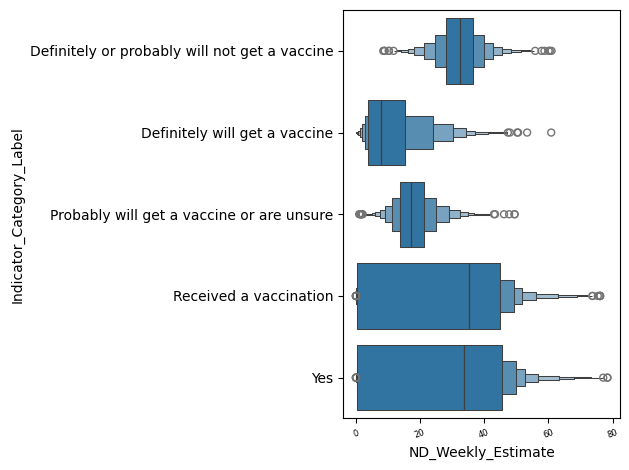

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Indicator_Category_Label', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

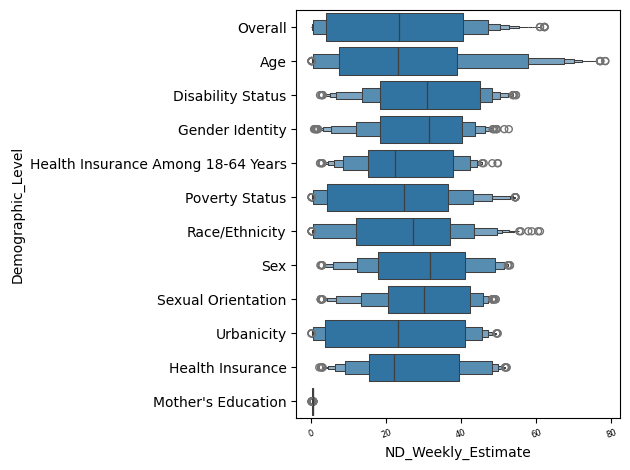

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Demographic_Level', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

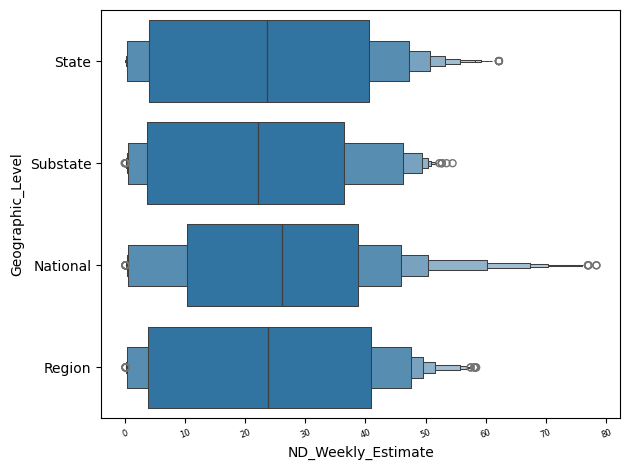

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Geographic_Level', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

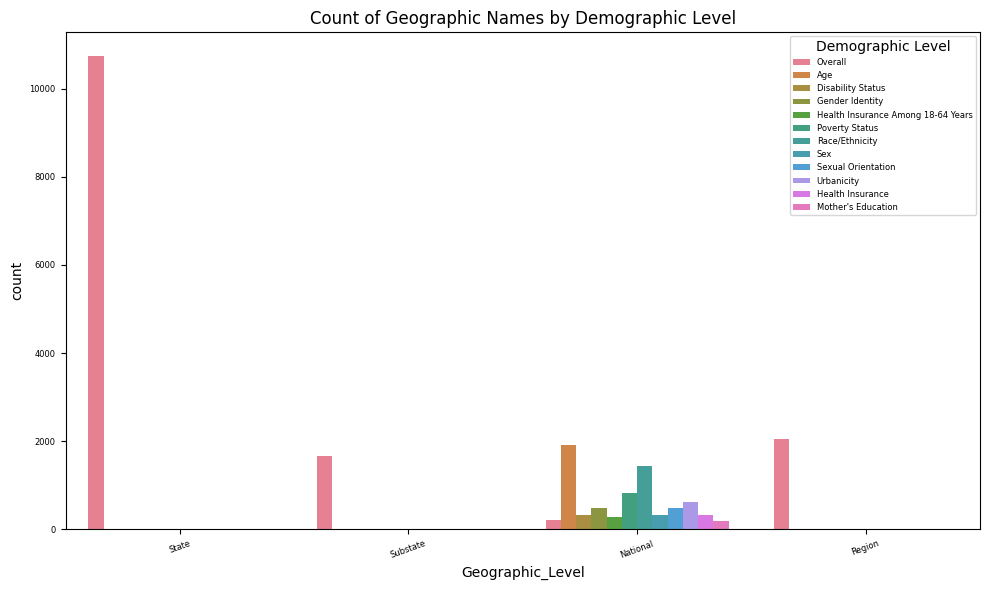

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Geographic_Level', hue='Demographic_Level')
plt.xticks(fontsize=6, rotation=20)
plt.yticks(fontsize=6)
plt.title('Count of Geographic Names by Demographic Level')
plt.legend(title='Demographic Level', fontsize=6)
plt.tight_layout()
plt.show()

In [21]:
df['Demographic_Name'].unique()

array(['18+ years', '18-29 years', '18-49 years', '30-39 years',
       '40-49 years', '50-64 years', '60+ years', '65+ years',
       '65-74 years', '75+ years', 'No', 'Yes', 'Cisgender', 'Uninsured',
       'Above Poverty, Income < $75k', 'Above Poverty, Income >= $75k',
       'Below Poverty', 'Poverty Status Unknown',
       'American Indian/Alaska Native, Non-Hispanic',
       'Asian, Non-Hispanic', 'Black, Non-Hispanic', 'Hispanic',
       'Multiple or Other Races, Non-Hispanic', 'Other, Non-Hispanic',
       'Pacific Islander/Native Hawaiian, Non-Hispanic',
       'White, Non-Hispanic', 'Female', 'Male', "Don't Know/Refused",
       'Gay/Lesbian/Bisexual/Other', 'Straight', 'Rural (Non-MSA)',
       'Suburban (MSA Non-Principal City)', 'Urban (MSA Principal City)',
       'Transgender/Nonbinary', 'Insured', '6 months-4 years',
       '6-23 months', '>= College degree', 'High school or equivalent',
       'Less than high school', 'Overall', '12-17 years', '13-17 years',
       '5

In [22]:
df['Demographic_Level'].value_counts()

,count
Demographic_Level,
Overall,14658
Age,1905
Race/Ethnicity,1434
Poverty Status,816
Urbanicity,612
Gender Identity,477
Sexual Orientation,477
Disability Status,318
Sex,318


In [23]:
df['Demographic_Name'].value_counts()

,count
Demographic_Name,
18+ years,11386
Overall,3272
50-64 years,318
Don't Know/Refused,318
Uninsured,300
Insured,300
Urban (MSA Principal City),204
Suburban (MSA Non-Principal City),204
Rural (Non-MSA),204


In [24]:
df['Current_Season_Week_Ending'].unique()

array(['01/27/2024 12:00:00 AM', '02/03/2024 12:00:00 AM',
       '01/06/2024 12:00:00 AM', '01/13/2024 12:00:00 AM',
       '01/20/2024 12:00:00 AM', '11/18/2023 12:00:00 AM',
       '11/25/2023 12:00:00 AM', '12/02/2023 12:00:00 AM',
       '10/07/2023 12:00:00 AM', '10/14/2023 12:00:00 AM',
       '10/21/2023 12:00:00 AM', '10/28/2023 12:00:00 AM',
       '11/04/2023 12:00:00 AM', '11/11/2023 12:00:00 AM',
       '09/30/2023 12:00:00 AM', '12/16/2023 12:00:00 AM',
       '02/10/2024 12:00:00 AM', '12/09/2023 12:00:00 AM',
       '03/16/2024 12:00:00 AM', '04/13/2024 12:00:00 AM',
       '12/23/2023 12:00:00 AM', '12/30/2023 12:00:00 AM',
       '05/11/2024 12:00:00 AM', '06/15/2024 12:00:00 AM',
       '03/02/2024 12:00:00 AM', '02/17/2024 12:00:00 AM',
       '03/09/2024 12:00:00 AM', '02/24/2024 12:00:00 AM',
       '03/31/2024 12:00:00 AM', '05/04/2024 12:00:00 AM',
       '03/23/2024 12:00:00 AM', '04/20/2024 12:00:00 AM',
       '04/06/2024 12:00:00 AM', '04/27/2024 12:00:00 AM

In [25]:
df.shape

(21795, 24)

In [26]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                     0
Geographic_Name                      0
Demographic_Level                    0
Demographic_Name                     0
Indicator_Label                      0
Indicator_Category_Label             0
Month_Week                           0
Week_Ending                      17533
ND_Weekly_Estimate                 287
CI_Half_width_95pct                287
n_unweighted                        14
Suppression_Flag                     8
Current_Season_Week_Ending           0
Influenza_Season                     0
Legend                               0
95 CI (%)                           93
Indicator_Category_Label_Sort     8516
Demographic_Level_Sort               0
Demographic_Name_Sort                0
Geographic_Sort                      0
Season_Sort                          0
Legend_Sort                          0
n_weighted                       17533
geography_name_order             17533
dtype: int64


In [27]:
df.shape

(21795, 24)

In [28]:
df.dropna(subset=['95 CI (%)'], inplace=True)

In [29]:
print(np.sum(df['95 CI (%)'].isnull(), axis=0))

0


In [30]:
df.shape

(21702, 24)

In [ ]:
n_mean = df['n_unweighted'].mean()
df['n_unweighted'].fillna(value=n_mean, inplace=True)

In [32]:
print(np.sum(df['n_unweighted'].isnull(), axis=0))

0


In [ ]:
nd_mean = df['ND_Weekly_Estimate'].mean()
df['ND_Weekly_Estimate'].fillna(value=nd_mean, inplace=True)
print(np.sum(df['ND_Weekly_Estimate'].isnull(), axis=0))

In [ ]:
suppression_mean = df['Suppression_Flag'].mean()
df['Suppression_Flag'].fillna(value=suppression_mean, inplace=True)
print(np.sum(df['Suppression_Flag'].isnull(), axis=0))

In [ ]:
ci_half_width_mean = df['CI_Half_width_95pct'].mean()
df['CI_Half_width_95pct'].fillna(value=ci_half_width_mean, inplace=True)
print(np.sum(df['CI_Half_width_95pct'].isnull(), axis=0))

In [ ]:
df['Indicator_Category_Label_Sort'].fillna(value=0, inplace=True)
print(np.sum(df['Indicator_Category_Label_Sort'].isnull(), axis=0))

In [37]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                     0
Geographic_Name                      0
Demographic_Level                    0
Demographic_Name                     0
Indicator_Label                      0
Indicator_Category_Label             0
Month_Week                           0
Week_Ending                      17440
ND_Weekly_Estimate                   0
CI_Half_width_95pct                  0
n_unweighted                         0
Suppression_Flag                     0
Current_Season_Week_Ending           0
Influenza_Season                     0
Legend                               0
95 CI (%)                            0
Indicator_Category_Label_Sort        0
Demographic_Level_Sort               0
Demographic_Name_Sort                0
Geographic_Sort                      0
Season_Sort                          0
Legend_Sort                          0
n_weighted                       17440
geography_name_order             17440
dtype: int64


In [38]:
df.head()

,Geographic_Level,Geographic_Name,Demographic_Level,Demographic_Name,Indicator_Label,Indicator_Category_Label,Month_Week,Week_Ending,ND_Weekly_Estimate,CI_Half_width_95pct,...,Legend,95 CI (%),Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
0,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,NaN,30.8,7.8784,...,"2023-2024, Arizona, Overall (18+ years)",22.9 - 38.7,4.0,1,1,14,3,3140101,NaN,NaN
1,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,NaN,6.8,4.1669,...,"2023-2024, Arizona, Overall (18+ years)",2.6 - 11.0,2.0,1,1,14,3,3140101,NaN,NaN
2,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,NaN,22.3,7.6134,...,"2023-2024, Arizona, Overall (18+ years)",14.7 - 29.9,3.0,1,1,14,3,3140101,NaN,NaN
3,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,1.0,1,1,14,3,3140101,NaN,NaN
4,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,0.0,1,1,14,3,3140101,NaN,NaN


In [39]:
df = df.drop(columns=['Week_Ending','n_weighted','geography_name_order'])

In [40]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                 0
Geographic_Name                  0
Demographic_Level                0
Demographic_Name                 0
Indicator_Label                  0
Indicator_Category_Label         0
Month_Week                       0
ND_Weekly_Estimate               0
CI_Half_width_95pct              0
n_unweighted                     0
Suppression_Flag                 0
Current_Season_Week_Ending       0
Influenza_Season                 0
Legend                           0
95 CI (%)                        0
Indicator_Category_Label_Sort    0
Demographic_Level_Sort           0
Demographic_Name_Sort            0
Geographic_Sort                  0
Season_Sort                      0
Legend_Sort                      0
dtype: int64


In [41]:
df['Age_Group'] = df['Demographic_Name'].where(df['Demographic_Name'].str.contains('years'))
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'ND_Weekly_Estimate', 'CI_Half_width_95pct',
       'n_unweighted', 'Suppression_Flag', 'Current_Season_Week_Ending',
       'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'Age_Group'],
      dtype='object')

In [42]:
df['Age_Group'].unique()

array(['18+ years', '18-29 years', '18-49 years', '30-39 years',
       '40-49 years', '50-64 years', '60+ years', '65+ years',
       '65-74 years', '75+ years', nan, '6 months-4 years', '12-17 years',
       '13-17 years', '5-11 years', '5-12 years', '5-17 years'],
      dtype=object)

In [43]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                    0
Geographic_Name                     0
Demographic_Level                   0
Demographic_Name                    0
Indicator_Label                     0
Indicator_Category_Label            0
Month_Week                          0
ND_Weekly_Estimate                  0
CI_Half_width_95pct                 0
n_unweighted                        0
Suppression_Flag                    0
Current_Season_Week_Ending          0
Influenza_Season                    0
Legend                              0
95 CI (%)                           0
Indicator_Category_Label_Sort       0
Demographic_Level_Sort              0
Demographic_Name_Sort               0
Geographic_Sort                     0
Season_Sort                         0
Legend_Sort                         0
Age_Group                        8529
dtype: int64


In [ ]:
df['Age_Group'] = df['Age_Group'].fillna(0)
df['Age_Group'] = df['Age_Group'].replace({
    '6 months-4 years': 1,
    '5-11 years': 2,
    '5-12 years': 3,
    '5-17 years' : 4,
    '12-17 years' : 5,
    '13-17 years' : 6,
    '18+ years' : 7,
    '18-29 years' : 8,
    '18-49 years' : 9,
    '30-39 years' : 10,
    '40-49 years' : 11,
    '50-64 years' : 12,
    '60+ years' : 13,
    '65+ years' : 14,
    '65-74 years' : 15,
    '75+ years' : 16
})

In [45]:
df['Month_Week'].unique()

array(['January Week 4', 'February Week 1', 'January Week 1',
       'January Week 2', 'January Week 3', 'November Week 3',
       'November Week 4', 'December Week 1', 'October Week 2',
       'October Week 3', 'October Week 4', 'October Week 5',
       'November Week 1', 'November Week 2', 'October Week 1', 'October',
       'November', 'December', 'February', 'December Week 2', 'March',
       'April', 'January', 'December Week 3', 'December Week 4',
       'December Week 5', 'May', 'June', 'March Week 1',
       'February Week 2', 'February Week 3', 'March Week 2',
       'March Week 3', 'February Week 4', 'March Week 5', 'May Week 1',
       'May Week 2', 'March Week 4', 'April Week 2', 'April Week 3',
       'April Week 1', 'April Week 4'], dtype=object)

In [46]:
df['Month'] = df['Month_Week'].str.extract(r'([A-Za-z]+)')[0]
df['Month'] = df['Month'].str.strip()
df['Month'].unique()

array(['January', 'February', 'November', 'December', 'October', 'March',
       'April', 'May', 'June'], dtype=object)

In [ ]:
df['Month'] = df['Month'].replace({
    'January' : 1,
    'February' : 2,
    'November' : 11,
    'December' : 12,
    'October' : 10,
    'March' : 3,
    'April' : 4,
    'May' : 5,
    'June' : 6
})

In [48]:
df['Geographic_Name'].unique()

array(['Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
       'Illinois-City of Chicago', 'Illinois-Rest of State',
       'New York-New York City', 'New York-Rest of State',
       'Pennsylvania-Philadelphia County', 'Pennsylvania-Rest of State',
       'Texas-Bexar County', 'Texas-City of Houston',
       'Texas-Rest of State', 'National', '

In [49]:
df['Geographic_Level'].value_counts()

,count
Geographic_Level,
State,10667
National,7321
Region,2040
Substate,1674


In [50]:
df['Age_Group'].value_counts()

,count
Age_Group,
7,11313
0,8529
12,318
14,159
16,159
8,159
15,159
13,159
11,159


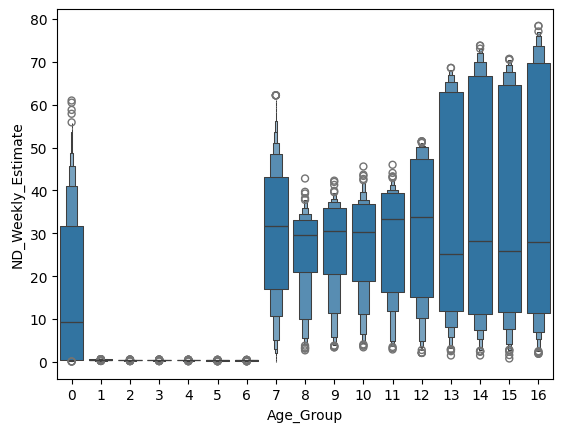

In [51]:
sns.boxenplot(data=df, x='Age_Group', y='ND_Weekly_Estimate')
plt.show()

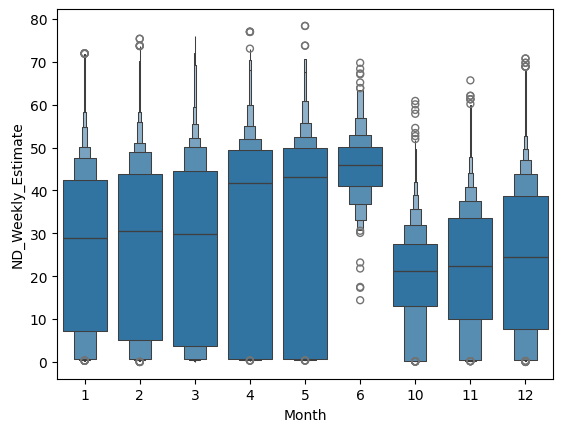

In [52]:
sns.boxenplot(data=df, x='Month', y='ND_Weekly_Estimate')
plt.show()

In [53]:
df_geographic_name = pd.get_dummies(df['Geographic_Name'], prefix='Geographic_Name_')
df = df.join(df_geographic_name)
df.drop(columns = 'Geographic_Name', inplace=True)

In [54]:
df_indicator_category_label = pd.get_dummies(df['Indicator_Category_Label'], prefix='Indicator_Category_Label_')
df = df.join(df_indicator_category_label)
df.drop(columns = 'Indicator_Category_Label', inplace=True)

In [55]:
df_demographic_name = pd.get_dummies(df['Demographic_Name'], prefix='Demographic_Name_')
df = df.join(df_demographic_name)
df.drop(columns = 'Demographic_Name', inplace=True)

In [56]:
df_influenza_season = pd.get_dummies(df['Influenza_Season'], prefix='Influenza_Season_')
df = df.join(df_influenza_season)
df.drop(columns = 'Influenza_Season', inplace=True)

In [57]:
feature_list = list(df.select_dtypes(include=['float64','boolean', 'int']).columns)
feature_list.remove('ND_Weekly_Estimate')
feature_list.remove('n_unweighted')
feature_list.remove('CI_Half_width_95pct')
feature_list.remove('Season_Sort')
feature_list.remove('Indicator_Category_Label_Sort')
feature_list.remove('Demographic_Name_Sort')
feature_list.remove('Geographic_Sort')
feature_list.remove('Legend_Sort')
feature_list.remove('Demographic_Name__Overall')
feature_list.remove('Demographic_Name__Yes')
feature_list.remove('Demographic_Level_Sort')
feature_list.remove('Suppression_Flag')
feature_list.remove('Indicator_Category_Label__Yes')

In [58]:
y = df['ND_Weekly_Estimate']
X = df[feature_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1234)

In [59]:
feature_list

['Age_Group',
 'Month',
 'Geographic_Name__Alabama',
 'Geographic_Name__Alaska',
 'Geographic_Name__Arizona',
 'Geographic_Name__Arkansas',
 'Geographic_Name__California',
 'Geographic_Name__Colorado',
 'Geographic_Name__Connecticut',
 'Geographic_Name__Delaware',
 'Geographic_Name__District of Columbia',
 'Geographic_Name__Florida',
 'Geographic_Name__Georgia',
 'Geographic_Name__Guam',
 'Geographic_Name__Hawaii',
 'Geographic_Name__Idaho',
 'Geographic_Name__Illinois',
 'Geographic_Name__Illinois-City of Chicago',
 'Geographic_Name__Illinois-Rest of State',
 'Geographic_Name__Indiana',
 'Geographic_Name__Iowa',
 'Geographic_Name__Kansas',
 'Geographic_Name__Kentucky',
 'Geographic_Name__Louisiana',
 'Geographic_Name__Maine',
 'Geographic_Name__Maryland',
 'Geographic_Name__Massachusetts',
 'Geographic_Name__Michigan',
 'Geographic_Name__Minnesota',
 'Geographic_Name__Mississippi',
 'Geographic_Name__Missouri',
 'Geographic_Name__Montana',
 'Geographic_Name__National',
 'Geographic_Na

In [60]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
predictions_dt = dt_model.predict(X_test)
mae_dt = mean_absolute_error(y_test, predictions_dt)
r2_dt = r2_score(y_test, predictions_dt)
mse_dt = mean_squared_error(y_test, predictions_dt)
rmse_dt = root_mean_squared_error(y_test, predictions_dt)

In [61]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = root_mean_squared_error(y_test, predictions_rf)

In [62]:
print("Model Comparison:")
print(f"{'Metric':<15} {'Random Forest':<15} {'Decision Tree':<15}")
print(f"{'-'*45}")

print(f"{'MAE':<15} {mae_rf:<15.4f} {mae_dt:<15.4f}")
print(f"{'R² Score':<15} {r2_rf:<15.4f} {r2_dt:<15.4f}")
print(f"{'MSE':<15} {mse_rf:<15.4f} {mse_dt:<15.4f}")
print(f"{'RMSE':<15} {rmse_rf:<15.4f} {rmse_dt:<15.4f}")

Model Comparison:
Metric          Random Forest   Decision Tree  
---------------------------------------------
MAE             3.0521          3.1007         
R² Score        0.8797          0.8747         
MSE             38.8842         40.4965        
RMSE            6.2357          6.3637         


In [63]:
df_pred_test = pd.DataFrame()

In [64]:
df_pred_test['ND_Weekly_Estimate'] = y_test

In [65]:
df_pred_test['Predictions_DT'] = predictions_dt

In [66]:
df_pred_test['Predictions_RF'] = predictions_rf

In [67]:
df_pred_test.head()

,ND_Weekly_Estimate,Predictions_DT,Predictions_RF
12897,39.8,39.80,39.800000
14175,38.1,37.70,37.791400
11384,48.1,48.15,48.142600
4552,28.4,28.75,28.846958
16788,3.7,3.45,3.407848


In [68]:
forest_importances = rf_model.feature_importances_

<ipython-input-69-f430b1421771>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


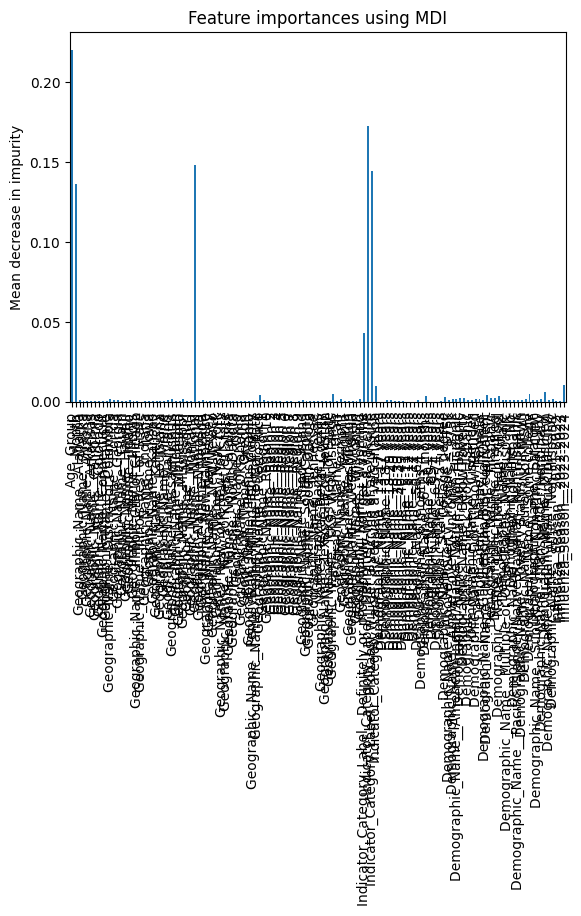

In [69]:
forest_importances_series = pd.Series(forest_importances, index=feature_list)
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances_series.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [70]:
df_features_imp = pd.DataFrame()

In [71]:
df_features_imp['DT_importances'] = dt_model.feature_importances_

In [72]:
df_features_imp['RF_importances'] = rf_model.feature_importances_

In [73]:
df_features_imp['Feature_list'] = feature_list

In [74]:
df_features_imp.head()

,DT_importances,RF_importances,Feature_list
0,0.222826,0.220237,Age_Group
1,0.134953,0.136489,Month
2,0.000819,0.000863,Geographic_Name__Alabama
3,0.000651,0.000761,Geographic_Name__Alaska
4,0.000416,0.000464,Geographic_Name__Arizona


In [75]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
predictions_lr = lr_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, predictions_lr)
r2_lr = r2_score(y_test, predictions_lr)
mse_lr = mean_squared_error(y_test, predictions_lr)
rmse_lr = root_mean_squared_error(y_test, predictions_lr)

In [76]:
print("Model Comparison:")
print(f"{'Metric':<15} {'Random Forest':<15} {'Decision Tree':<15} {'Linear Regression':<15}")
print(f"{'-'*60}")

print(f"{'MAE':<15} {mae_rf:<15.4f} {mae_dt:<15.4f} {mae_lr:<15.4f}")
print(f"{'R² Score':<15} {r2_rf:<15.4f} {r2_dt:<15.4f} {r2_lr:<15.4f}")
print(f"{'MSE':<15} {mse_rf:<15.4f} {mse_dt:<15.4f} {mse_lr:<15.4f}")
print(f"{'RMSE':<15} {rmse_rf:<15.4f} {rmse_dt:<15.4f} {rmse_lr:<15.4f}")

Model Comparison:
Metric          Random Forest   Decision Tree   Linear Regression
------------------------------------------------------------
MAE             3.0521          3.1007          7.8489         
R² Score        0.8797          0.8747          0.6557         
MSE             38.8842         40.4965         111.2429       
RMSE            6.2357          6.3637          10.5472        


In [77]:
en_model = ElasticNet()
en_model.fit(X_train, y_train)
predictions_en = en_model.predict(X_test)
mae_en = mean_absolute_error(y_test, predictions_en)
r2_en = r2_score(y_test, predictions_en)
mse_en = mean_squared_error(y_test, predictions_en)
rmse_en = np.sqrt(mse_en)

In [ ]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train)
predictions_cb = cb_model.predict(X_test)
mae_cb = mean_absolute_error(y_test, predictions_cb)
r2_cb = r2_score(y_test, predictions_cb)
mse_cb = mean_squared_error(y_test, predictions_cb)
rmse_cb = np.sqrt(mse_cb)

In [79]:
print("Model Comparison:")
print(f"{'Metric':<12} {'Random Forest':<15} {'Decision Tree':<15} {'Linear Regression':<18} {'Elastic Net':<15} {'CatBoost':<15}")
print("="*90)

print(f"{'MAE':<12} {mae_rf:<15.4f} {mae_dt:<15.4f} {mae_lr:<18.4f} {mae_en:<15.4f} {mae_cb:<15.4f}")
print(f"{'R² Score':<12} {r2_rf:<15.4f} {r2_dt:<15.4f} {r2_lr:<18.4f} {r2_en:<15.4f} {r2_cb:<15.4f}")
print(f"{'MSE':<12} {mse_rf:<15.4f} {mse_dt:<15.4f} {mse_lr:<18.4f} {mse_en:<15.4f} {mse_cb:<15.4f}")
print(f"{'RMSE':<12} {rmse_rf:<15.4f} {rmse_dt:<15.4f} {rmse_lr:<18.4f} {rmse_en:<15.4f} {rmse_cb:<15.4f}")

Model Comparison:
Metric       Random Forest   Decision Tree   Linear Regression  Elastic Net     CatBoost       
MAE          3.0521          3.1007          7.8489             13.7854         3.8211         
R² Score     0.8797          0.8747          0.6557             0.2310          0.8862         
MSE          38.8842         40.4965         111.2429           248.4803        36.7565        
RMSE         6.2357          6.3637          10.5472            15.7633         6.0627         


In [80]:
df_pred_test['Predictions_LR'] = predictions_lr
df_pred_test['Predictions_EN'] = predictions_en
df_pred_test['Predictions_CB'] = predictions_cb

In [81]:
df_pred_test.head(10)

,ND_Weekly_Estimate,Predictions_DT,Predictions_RF,Predictions_LR,Predictions_EN,Predictions_CB
12897,39.800,39.800,39.800000,39.850586,31.515901,43.868952
14175,38.100,37.700,37.791400,37.373535,38.108519,39.672971
11384,48.100,48.150,48.142600,37.435547,30.220792,46.413897
4552,28.400,28.750,28.846958,36.333008,16.426923,26.685342
16788,3.700,3.450,3.407848,12.873047,27.715111,3.726811
2666,24.700,22.900,21.765790,8.005859,15.041673,23.911457
15120,52.100,52.100,51.972248,38.289551,29.248321,48.887964
12383,41.000,41.225,41.156328,36.481934,19.507934,34.012317
10964,49.300,49.300,49.311917,39.500000,30.220792,46.859883
18207,0.356,0.356,0.828102,2.185059,14.250730,-0.227169


In [82]:
lr_coef = lr_model.coef_
importance_df_lr = pd.DataFrame({'Feature': feature_list, 'Coefficient': lr_coef})
importance_df_lr['Absolute Coefficient'] = importance_df_lr['Coefficient'].abs()
importance_df = importance_df_lr.sort_values(by='Absolute Coefficient', ascending=False)
importance_df

,Feature,Coefficient,Absolute Coefficient
128,Influenza_Season__2023-2024,-2.672664e+12,2.672664e+12
126,Influenza_Season__2021-2022,-2.672664e+12,2.672664e+12
127,Influenza_Season__2022-2023,-2.672664e+12,2.672664e+12
96,Demographic_Name__75+ years,-2.156082e+12,2.156082e+12
95,Demographic_Name__65-74 years,-2.021327e+12,2.021327e+12
...,...,...,...
102,Demographic_Name__Below Poverty,7.651487e+00,7.651487e+00
109,Demographic_Name__Hispanic,7.623219e+00,7.623219e+00
76,Indicator_Category_Label__Definitely or probab...,-3.669281e+00,3.669281e+00
79,Indicator_Category_Label__Received a vaccination,1.797579e+00,1.797579e+00


In [83]:
en_coef = en_model.coef_
importance_df_en = pd.DataFrame({'Feature': feature_list, 'Coefficient': en_coef})
importance_df_en['Absolute Coefficient'] = importance_df_en['Coefficient'].abs()
importance_df_en = importance_df_en.sort_values(by='Absolute Coefficient', ascending=False)
importance_df_en

,Feature,Coefficient,Absolute Coefficient
77,Indicator_Category_Label__Definitely will get ...,-2.505681,2.505681
0,Age_Group,1.602556,1.602556
32,Geographic_Name__National,1.367320,1.367320
128,Influenza_Season__2023-2024,-1.225467,1.225467
78,Indicator_Category_Label__Probably will get a ...,-1.062613,1.062613
...,...,...,...
40,Geographic_Name__New York-Rest of State,-0.000000,0.000000
39,Geographic_Name__New York-New York City,-0.000000,0.000000
38,Geographic_Name__New York,-0.000000,0.000000
37,Geographic_Name__New Mexico,-0.000000,0.000000


In [84]:
df_features_imp['LR_importances'] = importance_df_lr['Coefficient']
df_features_imp['EN_importances'] = importance_df_en['Coefficient']
df_features_imp['CB_importances'] = cb_model.feature_importances_

In [85]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['LR_importances'],
    mode='markers',
    name='Linear Regression',
    marker=dict(color='red', symbol='circle'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['EN_importances'],
    mode='markers',
    name='Elastic Net',
    marker=dict(color='blue', symbol='x'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['RF_importances'],
    mode='markers',
    name='Random Forest',
    marker=dict(color='green', symbol='square'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['DT_importances'],
    mode='markers',
    name='Decision Tree',
    marker=dict(color='orange', symbol='diamond'),
    showlegend=True
))
fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['CB_importances'],
    mode='markers',
    name='CatBoost',
    marker=dict(color='purple', symbol='star'),
    showlegend=True
))
fig.update_layout(
    title='Feature Importances Comparison: LR, EN, RF, DT, CB',
    xaxis_title='Features',
    yaxis_title='Importance',
    xaxis_tickangle=-45,
    legend_title_text='Models',
    template='plotly_white'
)


fig.show()

In [86]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_lr,
    mode='markers',
    name='Linear Regression Predictions',
    marker=dict(color='red', symbol='x')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_dt,
    mode='markers',
    name='Decision Tree Predictions',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_rf,
    mode='markers',
    name='Random Forest Predictions',
    marker=dict(color='orange', symbol='square')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_en,
    mode='markers',
    name='Elastic Net Predictions',
    marker=dict(color='purple', symbol='diamond')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_cb,
    mode='markers',
    name='CatBoost Predictions',
    marker=dict(color='blue', symbol='star')
))

max_value = max(y_test.max(), predictions_lr.max(), predictions_dt.max(), predictions_rf.max(), predictions_en.max(), predictions_cb.max())
min_value = min(y_test.min(), predictions_lr.min(), predictions_dt.min(), predictions_rf.min(), predictions_en.min(), predictions_cb.min())

fig.add_trace(go.Scatter(
    x=[min_value, max_value],
    y=[min_value, max_value],
    mode='lines',
    name='Perfect Prediction Line',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    xaxis_title='Actual Values (y_test)',
    yaxis_title='Predicted Values',
    title='Model Predictions Comparison',
    legend_title_text='Models',
    template='plotly_white'
)

fig.show()


In [87]:
df_features_imp.sort_values(by="DT_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
0,2.228258e-01,2.202371e-01,Age_Group,1.347551e+11,1.602556,27.200973
77,1.768284e-01,1.727042e-01,Indicator_Category_Label__Definitely will get ...,-2.500643e+01,-2.505681,21.286628
32,1.508106e-01,1.479781e-01,Geographic_Name__National,-2.008504e+10,1.367320,11.124700
78,1.487324e-01,1.443249e-01,Indicator_Category_Label__Probably will get a ...,-1.809485e+01,-1.062613,12.740851
1,1.349530e-01,1.364894e-01,Month,-3.381348e-01,-0.486235,13.692540
...,...,...,...,...,...,...
81,2.606019e-10,5.379903e-10,Demographic_Name__13-17 years,-8.085306e+11,-0.000000,0.029659
88,1.638036e-10,1.968313e-10,Demographic_Name__5-12 years,-4.042653e+11,-0.000000,0.007546
80,1.574736e-10,2.300253e-10,Demographic_Name__12-17 years,-6.737755e+11,-0.000000,0.008933
87,7.485512e-11,1.954987e-10,Demographic_Name__5-11 years,-2.695102e+11,-0.000000,0.006443


In [88]:
df_features_imp.sort_values(by="RF_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
0,2.228258e-01,2.202371e-01,Age_Group,1.347551e+11,1.602556,27.200973
77,1.768284e-01,1.727042e-01,Indicator_Category_Label__Definitely will get ...,-2.500643e+01,-2.505681,21.286628
32,1.508106e-01,1.479781e-01,Geographic_Name__National,-2.008504e+10,1.367320,11.124700
78,1.487324e-01,1.443249e-01,Indicator_Category_Label__Probably will get a ...,-1.809485e+01,-1.062613,12.740851
1,1.349530e-01,1.364894e-01,Month,-3.381348e-01,-0.486235,13.692540
...,...,...,...,...,...,...
89,0.000000e+00,1.585906e-09,Demographic_Name__5-17 years,-5.390204e+11,-0.000000,0.008217
81,2.606019e-10,5.379903e-10,Demographic_Name__13-17 years,-8.085306e+11,-0.000000,0.029659
80,1.574736e-10,2.300253e-10,Demographic_Name__12-17 years,-6.737755e+11,-0.000000,0.008933
88,1.638036e-10,1.968313e-10,Demographic_Name__5-12 years,-4.042653e+11,-0.000000,0.007546


In [89]:
df_features_imp.sort_values(by="LR_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
0,0.222826,0.220237,Age_Group,1.347551e+11,1.602556,27.200973
106,0.001317,0.001878,Demographic_Name__Female,2.066870e+01,0.000000,0.221076
101,0.002107,0.002542,"Demographic_Name__Asian, Non-Hispanic",1.970987e+01,0.000000,0.210294
104,0.001012,0.001406,Demographic_Name__Cisgender,1.945378e+01,0.000000,0.123945
110,0.002154,0.002195,Demographic_Name__Insured,1.919586e+01,0.000000,0.271978
...,...,...,...,...,...,...
95,0.000019,0.000049,Demographic_Name__65-74 years,-2.021327e+12,-0.000000,0.003226
96,0.000279,0.000191,Demographic_Name__75+ years,-2.156082e+12,-0.000000,0.004771
127,0.000263,0.000263,Influenza_Season__2022-2023,-2.672664e+12,0.188444,0.020200
126,0.000305,0.000268,Influenza_Season__2021-2022,-2.672664e+12,0.037022,0.025689


In [90]:
df_features_imp.sort_values(by="EN_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
0,0.222826,0.220237,Age_Group,1.347551e+11,1.602556,27.200973
32,0.150811,0.147978,Geographic_Name__National,-2.008504e+10,1.367320,11.124700
82,0.000242,0.001358,Demographic_Name__18+ years,-9.432858e+11,0.862288,0.643150
79,0.007756,0.009884,Indicator_Category_Label__Received a vaccination,1.797579e+00,0.808873,1.849940
76,0.044818,0.043310,Indicator_Category_Label__Definitely or probab...,-3.669281e+00,0.518770,4.653182
...,...,...,...,...,...,...
5,0.000300,0.000381,Geographic_Name__Arkansas,-2.008504e+10,-0.000000,0.007332
1,0.134953,0.136489,Month,-3.381348e-01,-0.486235,13.692540
78,0.148732,0.144325,Indicator_Category_Label__Probably will get a ...,-1.809485e+01,-1.062613,12.740851
128,0.010421,0.010267,Influenza_Season__2023-2024,-2.672664e+12,-1.225467,1.372782


In [91]:
df_features_imp.sort_values(by="CB_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
0,0.222826,0.220237,Age_Group,1.347551e+11,1.602556,27.200973
77,0.176828,0.172704,Indicator_Category_Label__Definitely will get ...,-2.500643e+01,-2.505681,21.286628
1,0.134953,0.136489,Month,-3.381348e-01,-0.486235,13.692540
78,0.148732,0.144325,Indicator_Category_Label__Probably will get a ...,-1.809485e+01,-1.062613,12.740851
32,0.150811,0.147978,Geographic_Name__National,-2.008504e+10,1.367320,11.124700
...,...,...,...,...,...,...
55,0.000126,0.000102,Geographic_Name__Region 5,-2.008504e+10,-0.000000,0.000000
90,0.001964,0.001202,Demographic_Name__50-64 years,-1.617061e+12,-0.000000,0.000000
93,0.000033,0.000079,Demographic_Name__60+ years,-1.751816e+12,-0.000000,0.000000
18,0.000081,0.000114,Geographic_Name__Illinois-Rest of State,-2.008504e+10,-0.000000,0.000000


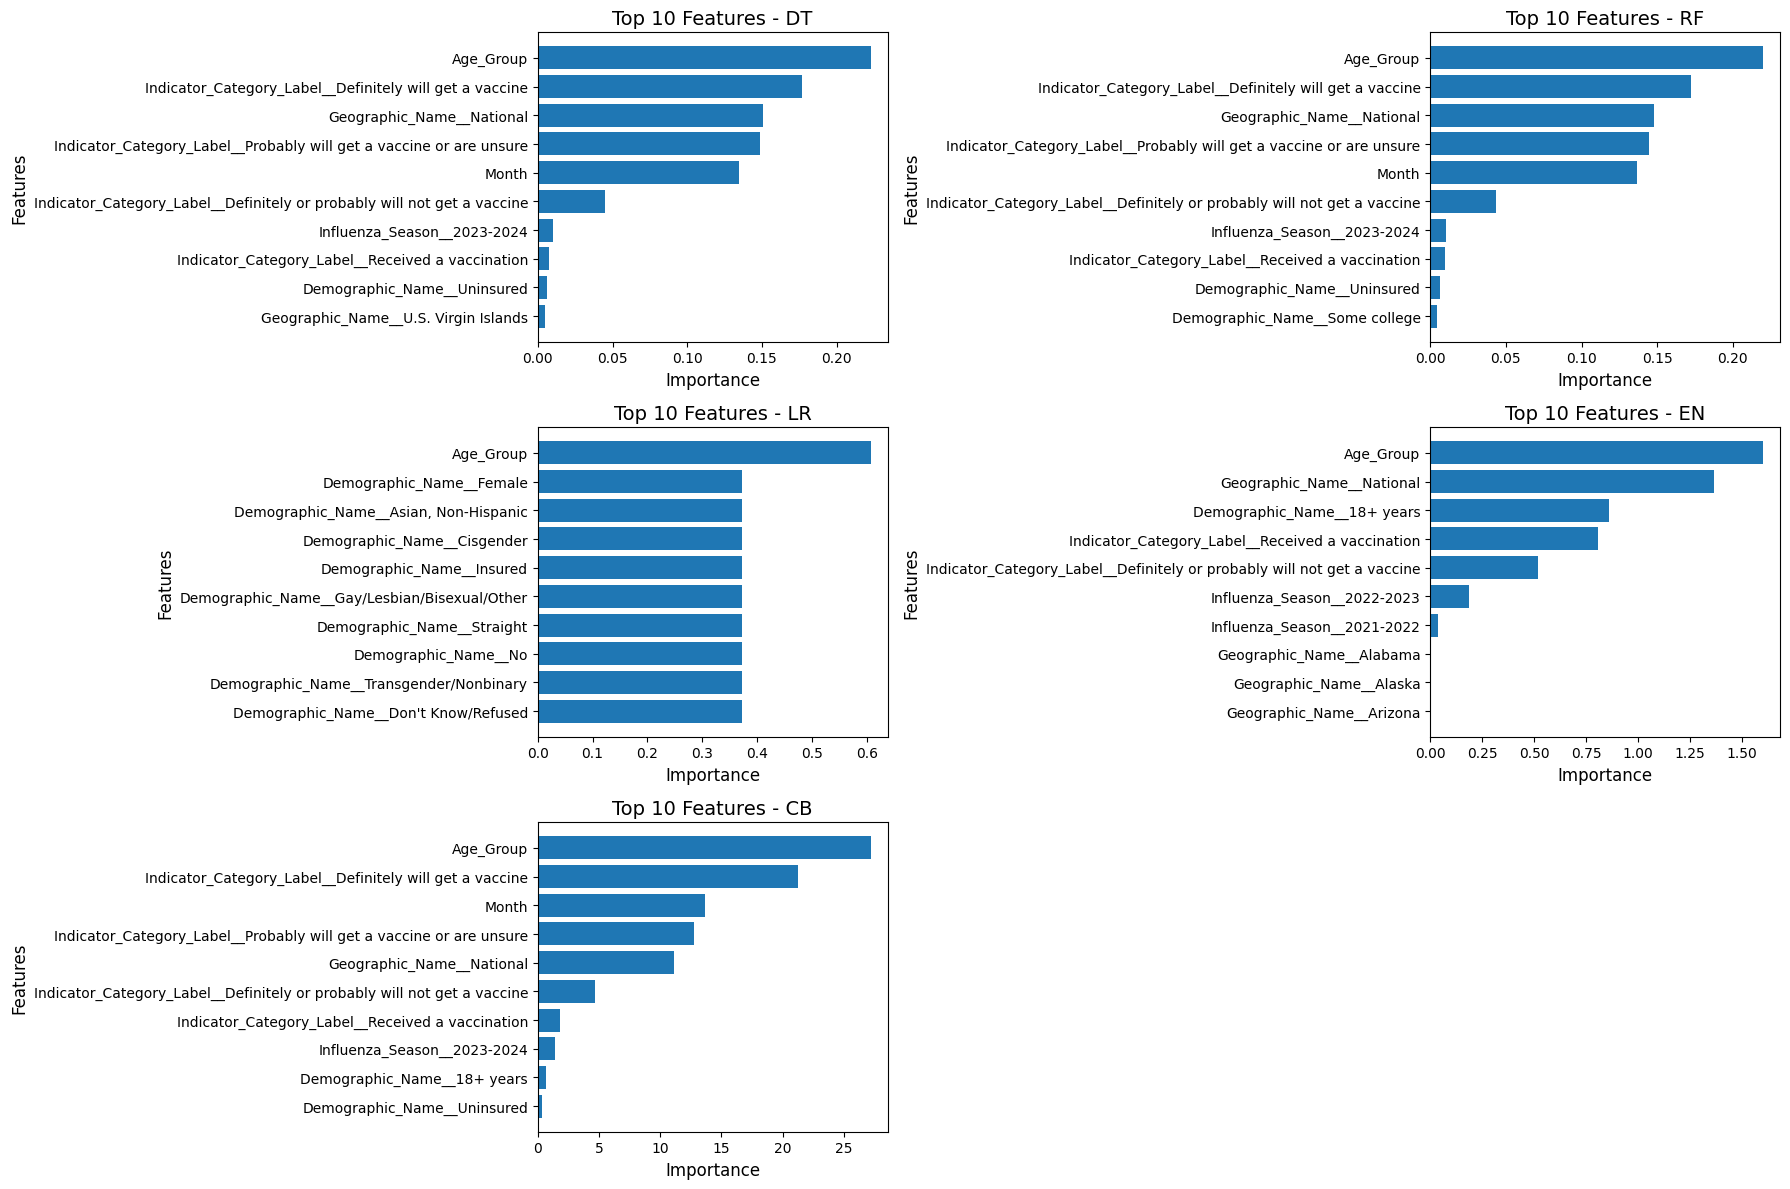

Top Features List:
DT: ['Age_Group', 'Indicator_Category_Label__Definitely will get a vaccine', 'Geographic_Name__National', 'Indicator_Category_Label__Probably will get a vaccine or are unsure', 'Month', 'Indicator_Category_Label__Definitely or probably will not get a vaccine', 'Influenza_Season__2023-2024', 'Indicator_Category_Label__Received a vaccination', 'Demographic_Name__Uninsured', 'Geographic_Name__U.S. Virgin Islands']
RF: ['Age_Group', 'Indicator_Category_Label__Definitely will get a vaccine', 'Geographic_Name__National', 'Indicator_Category_Label__Probably will get a vaccine or are unsure', 'Month', 'Indicator_Category_Label__Definitely or probably will not get a vaccine', 'Influenza_Season__2023-2024', 'Indicator_Category_Label__Received a vaccination', 'Demographic_Name__Uninsured', 'Demographic_Name__Some college']
LR: ['Age_Group', 'Demographic_Name__Female', 'Demographic_Name__Asian, Non-Hispanic', 'Demographic_Name__Cisgender', 'Demographic_Name__Insured', 'Demograph

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features_imp['LR_importances'] = scaler.fit_transform(df_features_imp[['LR_importances']])

models = ['DT_importances', 'RF_importances', 'LR_importances', 'EN_importances', 'CB_importances']
num_features = 10
top_features_list = {}

plt.figure(figsize=(18, 12))

for i, model in enumerate(models):
    top_features = df_features_imp.nlargest(num_features, model)
    top_features_list[model] = top_features['Feature_list'].tolist()

    plt.subplot(3, 2, i + 1)
    plt.barh(top_features['Feature_list'], top_features[model])
    plt.title(f'Top 10 Features - {model[:-12]}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("Top Features List:")
for model, features in top_features_list.items():
    print(f"{model[:-12]}: {features}")

In [93]:
df_pred_test['Error_LR'] = abs(df_pred_test['Predictions_LR'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_DT'] = abs(df_pred_test['Predictions_DT'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_RF'] = abs(df_pred_test['Predictions_RF'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_EN'] = abs(df_pred_test['Predictions_EN'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_CB'] = abs(df_pred_test['Predictions_CB'] - df_pred_test['ND_Weekly_Estimate'])

worst_performers_dt = df_pred_test.nlargest(10, 'Error_DT')
worst_performers_rf = df_pred_test.nlargest(10, 'Error_RF')
worst_performers_lr = df_pred_test.nlargest(10, 'Error_LR')
worst_performers_en = df_pred_test.nlargest(10, 'Error_EN')
worst_performers_cb = df_pred_test.nlargest(10, 'Error_CB')

columns_to_display = ['ND_Weekly_Estimate', 'Predictions_DT', 'Predictions_RF', 'Predictions_LR', 'Predictions_EN', 'Predictions_CB']

with pd.option_context('display.width', 1000):
    print("Worst Performing Data Points for DT:")
    print(worst_performers_dt[columns_to_display])

    print("\nWorst Performing Data Points for RF:")
    print(worst_performers_rf[columns_to_display])

    print("\nWorst Performing Data Points for LR:")
    print(worst_performers_lr[columns_to_display])

    print("\nWorst Performing Data Points for EN:")
    print(worst_performers_en[columns_to_display])

    print("\nWorst Performing Data Points for CB:")
    print(worst_performers_cb[columns_to_display])

Worst Performing Data Points for DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB
21629               0.567       54.233333       52.835834       32.223633       19.021698       36.272307
21451               0.567       54.233333       52.835834       32.223633       19.021698       36.272307
21492               0.567       54.233333       52.835834       32.223633       19.021698       36.272307
21736               0.568       54.233333       52.835834       32.223633       19.021698       36.272307
14995              46.100        0.515000        2.683970       27.791504       18.535463       23.654638
15050              46.100        0.515000        2.683970       27.791504       18.535463       23.654638
11634              47.900        9.671800       10.377202       30.056152       15.940688       16.042555
10336              47.700        9.671800       10.377202       30.056152       15.940688       16.042555
21307    

In [94]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=worst_performers_dt['ND_Weekly_Estimate'],
    y=worst_performers_dt['Predictions_DT'],
    mode='markers',
    name='Decision Tree Predictions',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=worst_performers_rf['ND_Weekly_Estimate'],
    y=worst_performers_rf['Predictions_RF'],
    mode='markers',
    name='Random Forest Predictions',
    marker=dict(color='orange', symbol='square')
))

fig.add_trace(go.Scatter(
    x=worst_performers_lr['ND_Weekly_Estimate'],
    y=worst_performers_lr['Predictions_LR'],
    mode='markers',
    name='Linear Regression Predictions',
    marker=dict(color='red', symbol='x')
))

fig.add_trace(go.Scatter(
    x=worst_performers_en['ND_Weekly_Estimate'],
    y=worst_performers_en['Predictions_EN'],
    mode='markers',
    name='Elastic Net Predictions',
    marker=dict(color='purple', symbol='diamond')
))

fig.add_trace(go.Scatter(
    x=worst_performers_cb['ND_Weekly_Estimate'],
    y=worst_performers_cb['Predictions_CB'],
    mode='markers',
    name='CatBoost Predictions',
    marker=dict(color='blue', symbol='star')
))

max_value = max(
    worst_performers_dt['ND_Weekly_Estimate'].max(),
    worst_performers_rf['ND_Weekly_Estimate'].max(),
    worst_performers_lr['ND_Weekly_Estimate'].max(),
    worst_performers_en['ND_Weekly_Estimate'].max(),
    worst_performers_cb['ND_Weekly_Estimate'].max(),
    worst_performers_dt['Predictions_DT'].max(),
    worst_performers_rf['Predictions_RF'].max(),
    worst_performers_lr['Predictions_LR'].max(),
    worst_performers_en['Predictions_EN'].max(),
    worst_performers_cb['Predictions_CB'].max()
)

min_value = min(
    worst_performers_dt['ND_Weekly_Estimate'].min(),
    worst_performers_rf['ND_Weekly_Estimate'].min(),
    worst_performers_lr['ND_Weekly_Estimate'].min(),
    worst_performers_en['ND_Weekly_Estimate'].min(),
    worst_performers_cb['ND_Weekly_Estimate'].min(),
    worst_performers_dt['Predictions_DT'].min(),
    worst_performers_rf['Predictions_RF'].min(),
    worst_performers_lr['Predictions_LR'].min(),
    worst_performers_en['Predictions_EN'].min(),
    worst_performers_cb['Predictions_CB'].min()
)

fig.add_trace(go.Scatter(
    x=[min_value, max_value],
    y=[min_value, max_value],
    mode='lines',
    name='Perfect Prediction Line',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    xaxis_title='Actual Values (ND Weekly Estimate)',
    yaxis_title='Predicted Values',
    title='Worst Performing Model Predictions Comparison',
    legend_title_text='Models',
    template='plotly_white'
)

fig.show()

In [95]:
columns_to_display = ['ND_Weekly_Estimate', 'Predictions_DT', 'Predictions_RF', 'Predictions_LR', 'Predictions_EN', 'Predictions_CB']

def display_worst_performers(worst_performers, model_name):
    indices = worst_performers.index
    feature_values = X_test.loc[indices]
    combined_df = pd.concat([worst_performers[columns_to_display], feature_values], axis=1)
    with pd.option_context('display.width', 10000):
        print(f"Worst Performing Data Points for {model_name}:")
        print(combined_df.head(10))

display_worst_performers(worst_performers_dt, 'DT')
display_worst_performers(worst_performers_rf, 'RF')
display_worst_performers(worst_performers_lr, 'LR')
display_worst_performers(worst_performers_en, 'EN')
display_worst_performers(worst_performers_cb, 'CB')

Worst Performing Data Points for DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB  Age_Group  Month  Geographic_Name__Alabama  Geographic_Name__Alaska  ...  Demographic_Name__Some college  Demographic_Name__Straight  Demographic_Name__Suburban (MSA Non-Principal City)  Demographic_Name__Transgender/Nonbinary  Demographic_Name__Uninsured  Demographic_Name__Urban (MSA Principal City)  Demographic_Name__White, Non-Hispanic  Influenza_Season__2021-2022  Influenza_Season__2022-2023  Influenza_Season__2023-2024
21629               0.567       54.233333       52.835834       32.223633       19.021698       36.272307          0      4                     False                    False  ...                           False                       False                                              False                                      False                        False                                         False                    

In [96]:
best_performers_dt = df_pred_test.nsmallest(10, 'Error_DT')
best_performers_rf = df_pred_test.nsmallest(10, 'Error_RF')
best_performers_lr = df_pred_test.nsmallest(10, 'Error_LR')
best_performers_en = df_pred_test.nsmallest(10, 'Error_EN')
best_performers_cb = df_pred_test.nsmallest(10, 'Error_CB')
def display_best_performers(best_performers, model_name):
    indices = best_performers.index
    feature_values = X_test.loc[indices]
    combined_df = pd.concat([best_performers[columns_to_display], feature_values], axis=1)
    with pd.option_context('display.width', 10000):
        print(f"Best Performing Data Points for {model_name}:")
        print(combined_df.head(10))

display_best_performers(best_performers_dt, 'DT')
display_best_performers(best_performers_rf, 'RF')
display_best_performers(best_performers_lr, 'LR')
display_best_performers(best_performers_en, 'EN')
display_best_performers(best_performers_en, 'CB')

Best Performing Data Points for DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB  Age_Group  Month  Geographic_Name__Alabama  Geographic_Name__Alaska  ...  Demographic_Name__Some college  Demographic_Name__Straight  Demographic_Name__Suburban (MSA Non-Principal City)  Demographic_Name__Transgender/Nonbinary  Demographic_Name__Uninsured  Demographic_Name__Urban (MSA Principal City)  Demographic_Name__White, Non-Hispanic  Influenza_Season__2021-2022  Influenza_Season__2022-2023  Influenza_Season__2023-2024
12897              39.800          39.800       39.800000       39.850586       31.515901       43.868952          7      2                      True                    False  ...                           False                       False                                              False                                      False                        False                                         False                     

In [99]:
def is_numeric_or_true(val, column_name):
    if column_name == 'Age_Group':
        return isinstance(val, (int, float)) or val is True
    else:
        return isinstance(val, (int, float)) and val != 0 or val is True

dataframes = [
    ('worst_performers_dt', worst_performers_dt),
    ('worst_performers_rf', worst_performers_rf),
    ('worst_performers_lr', worst_performers_lr),
    ('worst_performers_en', worst_performers_en),
    ('worst_performers_cb', worst_performers_cb),
    ('best_performers_dt', best_performers_dt),
    ('best_performers_rf', best_performers_rf),
    ('best_performers_lr', best_performers_lr),
    ('best_performers_en', best_performers_en),
    ('best_performers_cb', best_performers_cb)
]

def print_valid_columns(df, df_name):
    print(f"\nDisplaying values for {df_name}:")
    for idx, row in df.iterrows():
        valid_columns = row[[col for col in row.index if is_numeric_or_true(row[col], col)]]

        if not valid_columns.empty:
            print(f"\nRow {idx}:")
            for col, val in valid_columns.items():
                print(f"  {col}: {val}")

for df_name, df in dataframes:
    print_valid_columns(df, df_name)


Displaying values for worst_performers_dt:

Row 21629:
  ND_Weekly_Estimate: 0.567
  Predictions_DT: 54.23333333333333
  Predictions_RF: 52.835833690476186
  Predictions_LR: 32.2236328125
  Predictions_EN: 19.02169843831441
  Predictions_CB: 36.27230738790489
  Error_LR: 31.6566328125
  Error_DT: 53.66633333333333
  Error_RF: 52.268833690476185
  Error_EN: 18.45469843831441
  Error_CB: 35.70530738790489

Row 21451:
  ND_Weekly_Estimate: 0.567
  Predictions_DT: 54.23333333333333
  Predictions_RF: 52.835833690476186
  Predictions_LR: 32.2236328125
  Predictions_EN: 19.02169843831441
  Predictions_CB: 36.27230738790489
  Error_LR: 31.6566328125
  Error_DT: 53.66633333333333
  Error_RF: 52.268833690476185
  Error_EN: 18.45469843831441
  Error_CB: 35.70530738790489

Row 21492:
  ND_Weekly_Estimate: 0.567
  Predictions_DT: 54.23333333333333
  Predictions_RF: 52.835833690476186
  Predictions_LR: 32.2236328125
  Predictions_EN: 19.02169843831441
  Predictions_CB: 36.27230738790489
  Error_LR:

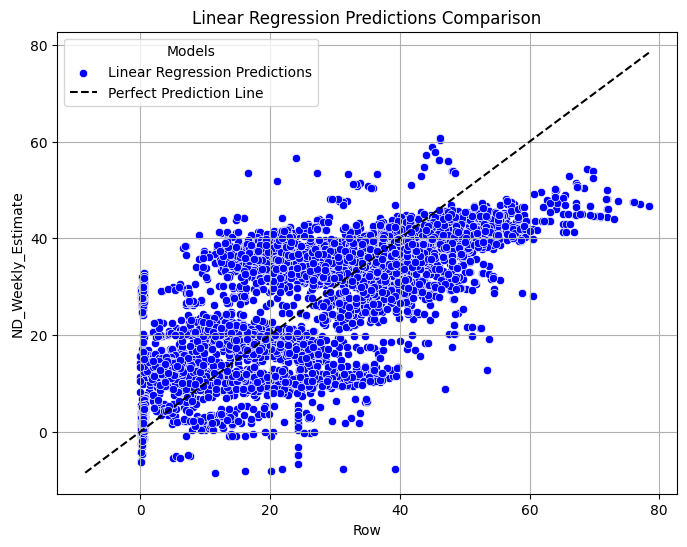

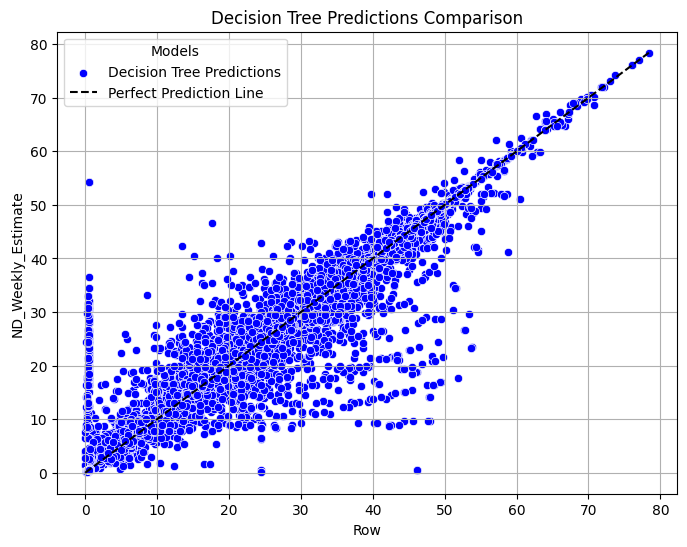

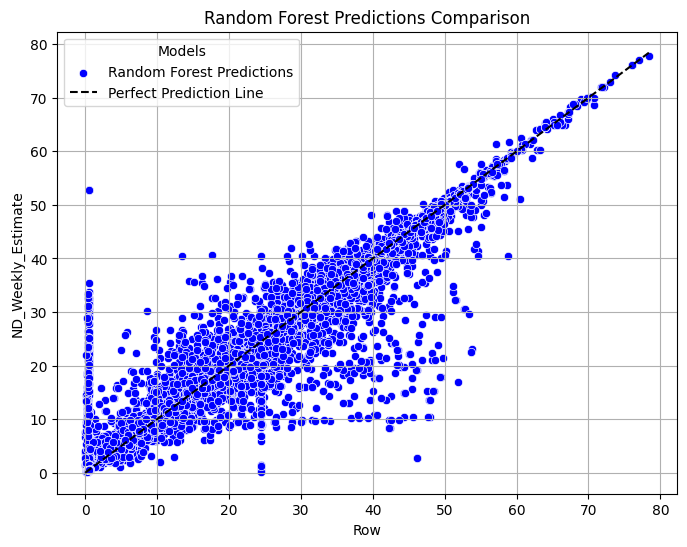

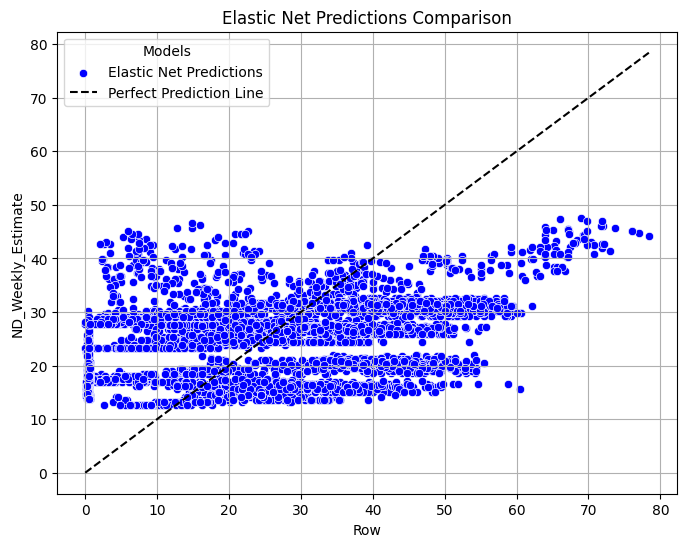

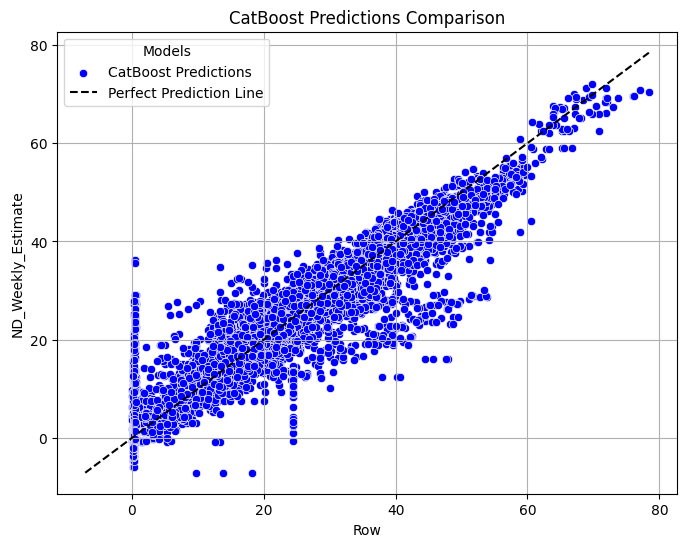

In [102]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Elastic Net', 'CatBoost']
predictions = [predictions_lr, predictions_dt, predictions_rf, predictions_en, predictions_cb]

for model, preds in zip(models, predictions):
    plt.figure(figsize=(8, 6))

    sns.scatterplot(x=y_test, y=preds, label=f'{model} Predictions', color='blue', marker='o')

    min_value = min(y_test.min(), preds.min())
    max_value = max(y_test.max(), preds.max())
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Perfect Prediction Line')

    plt.xlabel('Row')
    plt.ylabel('ND_Weekly_Estimate')
    plt.title(f'{model} Predictions Comparison')
    plt.legend(title='Models')
    plt.grid(True)

    plt.show()